In [1]:
from obspy import read_events, Catalog, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geothermie_plot_function import *

In [2]:
threshold_event_magnitude = 0.5

In [3]:
catalog = read_events('Downloads/geothermie-events-master/geothermie-events-master/Unterhaching/*.xml')
catnew = Catalog()
cat2013 = Catalog()
eventinfo = []
eventinfo2 = []
for event in catalog:
    try:
        if not (event.origins[0]['time'] > UTCDateTime(2013,1,1) and event.origins[0]['time'] < UTCDateTime(2014,1,1)):
            catnew.append(event)
            eventinfo.append([event.origins[0]['time'],event.magnitudes[0].mag])
        else:
            cat2013.append(event)
            eventinfo2.append([event.origins[0]['time'],event.magnitudes[0].mag])
    except:
        pass
catalog = catnew
roundedtimes = []
magnitudes = []
for time in eventinfo:
    rtime = float(UTCDateTime(time[0].year,time[0].month,time[0].day,time[0].hour))
    roundedtimes.append(rtime)
    magnitudes.append(time[1])
roundedtimes, magnitudes = zip(*sorted(zip(roundedtimes, magnitudes)))
print(catalog)
names = 'Time,Flowrate,Temperature,Pressure'
names = names.split(",")
data = pd.read_csv('Dokumente/unterhaching_betriebsdaten_2008-2017/daten20082017.txt',names=names,skiprows=1,delimiter=' ')
N = len(data)
newcol = np.zeros(N)
newcol2 = np.zeros(N)
flc = np.zeros(N)
tc = np.zeros(N)
pc = np.zeros(N)

ievent = 0

eventtimes = np.zeros(N)
eventtimes[0] = 100*365*24
eventtimes[1] = eventtimes[0]+1
newcol2[0] = np.nan
for i in range(1,N):
    if data['Time'][i] in roundedtimes:
        newcol[i] = 1
        N_events_in_this_hour = roundedtimes.count(data['Time'][i])
        
        ## get top magnitude of events in this hour
        mag = max(magnitudes[ievent:ievent+N_events_in_this_hour])
        newcol2[i] = mag
        if mag > threshold_event_magnitude:
            eventtimes[i+1] = 0
        else:
            eventtimes[i+1] = eventtimes[i]+1
        
        ievent += N_events_in_this_hour
    else:
        newcol2[i] = np.nan
        if i!=N-1:
            eventtimes[i+1] = eventtimes[i]+1
        
            
    
    if i==43022:
        roundedtimes2 = []
        magnitudes2 = []
        for time in eventinfo2:
            rtime = float(UTCDateTime(time[0].year,time[0].month,time[0].day,time[0].hour))
            roundedtimes2.append(rtime)
            magnitudes2.append(time[1])
        roundedtimes2, magnitudes2 = zip(*sorted(zip(roundedtimes2, magnitudes2)))
        roundedtimes2 = list(roundedtimes2)
        magnitudes2 = list(magnitudes2)
        roundedtimes2.reverse()
        magnitudes2.reverse()
        check = True
        mag = -100
        eventindex = -1
        while (mag < threshold_event_magnitude and check):
            eventindex += 1
            mag = magnitudes2[eventindex]
            if eventindex==len(magnitudes2):
                check = False
        eventtimes[i] = (float(UTCDateTime(2014,1,1))-roundedtimes2[eventindex])/(60**2)

drop = []
for i in range(N):
    if np.isnan(data['Flowrate'][i]):
        drop.append(i)
data.drop(drop)
N = len(data)

for i in range(1,N-1):
    flc[i] = data['Flowrate'][i+1]-data['Flowrate'][i-1]
    tc[i] = data['Temperature'][i+1]-data['Temperature'][i-1]
    pc[i] = data['Pressure'][i+1]-data['Pressure'][i-1]
    

#data['Flowrate diff'] = flc/2
#data['Temp diff'] = tc/2
#data['Press diff'] = pc/2
data['Quiet time'] = eventtimes
data['Event'] = newcol
data['Magnitude'] = newcol2
names.extend(['Flowrate diff','Temp diff','Press diff','Quiet time','Event','Magnitude'])

509 Event(s) in Catalog:
2010-05-27T16:25:25.312700Z | +48.048,  +11.644 | 0.0839474806054 Ml
2010-01-31T08:00:57.025500Z | +48.048,  +11.643 | 0.039033276658 Ml
...
2019-01-18T21:53:12.483393Z | +48.049,  +11.646 | -0.472072504528 None
2019-12-31T17:47:30.953434Z | +48.045,  +11.644 | -0.497145528261 None
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [4]:
def Confusionmatrix(y,yhat,perc):
    N = len(y)
    C = [[0,0],[0,0]]
    for i in range(N):
        if y[i,0]==1. and yhat[i,0]>=perc:
            C[0][0] += 1
        elif y[i,0]==0. and yhat[i,0]>=perc:
            C[1][0] += 1
        elif y[i,0]==1. and yhat[i,0]<perc:
            C[0][1] += 1
        else:
            C[1][1] += 1
            
    print('True Positives:  ', C[0][0])
    print('False Positives: ', C[1][0])
    print('False Negatives: ', C[0][1])
    print('True Negatives:  ', C[1][1])
    return C

In [5]:
def plot_model_evolution(Loss,b,c,U,V,W):
    fig,ax = plt.subplots(nrows=6,figsize=(15,15),sharex=True)
    ax[0].plot(Loss,label='Loss')
    ax[0].set_yscale('log')
    ax[1].plot(c[:,0],label='c1')
    ax[1].plot(c[:,1],label='c2')
    ax[2].plot(b[:,0],label='b1')
    ax[2].plot(b[:,1],label='b2')
    ax[2].plot(b[:,2],label='b3')
    ax[3].plot(V[:,0,0],label='V11')
    ax[3].plot(V[:,0,1],label='V12')
    ax[3].plot(V[:,0,2],label='V13')
    ax[3].plot(V[:,1,0],label='V21')
    ax[3].plot(V[:,1,1],label='V22')
    ax[3].plot(V[:,1,2],label='V23')
    
    ulabels = [['U11','U12','U13'],['U21','U22','U23'],['U31','U32','U33']]
    wlabels = [['W11','W12','W13'],['W21','W22','W23'],['W31','W32','W33']]
    
    for i in range(3):
        for j in range(3):
            ax[4].plot(U[:,i,j],label=ulabels[i][j])
            ax[5].plot(W[:,i,j],label=wlabels[i][j])
            
    for i in range(6):
        ax[i].legend(fontsize=8)
    plt.show() 

In [6]:
def softmax(xx):
    z = np.zeros(len(xx))
    summa = 0
    for i in range(len(xx)):
        z[i] = np.exp(xx[i])
        summa += np.exp(xx[i])
    return z/summa

In [7]:
def ReLu(xx):
    zz = np.zeros(len(xx))
    for i in range(len(xx)):
        if xx[i]>0:
            zz[i] = xx[i]
    return zz

In [8]:
def delta(xx,yy):
    if xx==yy:
        return 1.
    else:
        return 0.

In [145]:
def initialization(Nit,Nin):

    U = np.zeros((Nit,Nin,Nin))
    W = np.zeros((Nit,Nin,Nin))
    b = np.zeros((Nit,Nin))
    V = np.zeros((Nit,2,Nin))
    c = np.zeros((Nit,2))

    dU = np.zeros((Nit,Nin,Nin))
    dW = np.zeros((Nit,Nin,Nin))
    db = np.zeros((Nit,Nin))
    dV = np.zeros((Nit,2,Nin))
    dc = np.zeros((Nit,2))

    yhat = np.zeros((Nit+1,N,2))

    Nrandom = 1000

    for i in range(Nin):
        for j in range(Nin):
            U[0,i,j] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
            W[0,i,j] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
        b[0,i]= (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom   
    for i in range(2):
        for k in range(Nin):
            V[0,i,k] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
        c[0,i] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom    

    Loss = np.zeros(Nit)

    return U,W,b,V,c,dU,dW,db,dV,dc,yhat,Loss

In [100]:
def prediction(b,c,U,V,W,x):
    N = len(x)
    Nin = np.shape(W)[0]
    a = np.zeros((N,Nin))
    h = np.zeros((N,Nin))
    o = np.zeros((N,2))
    yhat = np.zeros((N,2))
    a[0] = b + np.dot(U,x[0])
    h[0] = np.tanh(a[0])
    o[0] = c + np.dot(V,h[0])
    for t in range(0,N):
        a[t] = b + np.dot(W,h[t-1])+np.dot(U,x[t])
        h[t] = np.tanh(a[t])
        o[t] = c + np.dot(V,h[t])
        yhat[t,:] = softmax(o[t,:])
    return h,o,yhat

def get_loss(y,yhat):
    N = len(y)
    Loss = 0
    for t in range(N):
        Loss -= y[t,0]*np.log10(yhat[t,0])+(1-y[t,0])*np.log10(yhat[t,1])
    return Loss

def gradients(h,o,V,W,x,y,yhat):
    N = len(x)
    Nin = np.shape(W)[0]
    do = np.zeros((N,2))
    for t in range(N):
        do[t,0] = y[t,0]*(1-yhat[t,0])-yhat[t,0]*(1-y[t,0])
        do[t,1] = -y[t,0]*yhat[t,1] * (1-y[t,0])*(1-yhat[t,1])
    do /= np.log(10)
    
    dh = np.zeros((N,Nin))
    dh[-1] = np.dot(V.transpose(),do[-1])
    for t in range(N-2,-1,-1):
        dig = []
        for i in range(Nin):
            dig.append(1-h[t+1,i]**2)
        diag = np.diag(np.array(dig))

        dh[t] = np.dot(np.dot(W.transpose(),diag),dh[t+1])+np.dot(V.transpose(),do[t])

    dc = np.zeros(2)
    for i in range(2):
        dc[i] = np.sum(do[:,i])
    db = np.zeros(Nin)
    dV = np.zeros((2,Nin))
    dW = np.zeros((Nin,Nin))
    dU = np.zeros((Nin,Nin))
    for i in range(Nin):
        for t in range(N):
            db[i] += (1-h[t,i]**2)*dh[t,i]
    
    for t in range(N):
        for i in range(2):
            for j in range(Nin):
                dV[i,j] += do[t,i]*h[t,j]

    for t in range(1,N):
        mat = np.zeros((Nin,Nin))
        mat2 = np.zeros((Nin,Nin))
        for i in range(Nin):
            for j in range(Nin):
                mat[i,j] = dh[t,i] * h[t-1,j]
                mat2[i,j] = dh[t,i] * x[t,j]
        
        dig = []
        for i in range(Nin):
            dig.append(1-h[t,i]**2)
        diag = np.diag(np.array(dig))
        
        dW += np.dot(diag,mat)
        dU += np.dot(diag,mat2)
    return db,dc,do,dU,dV,dW

In [54]:
def mapx(x):
    Nt, Ni = np.shape(x)
    m = np.zeros((Ni,2))
    for i in range(Ni):
        m[i,0] = np.min(x[:,i])
        m[i,1] = np.max(x[:,i])
    newx = np.zeros(np.shape(x))
    for i in range(Ni):
        for t in range(Nt):
            newx[t,i] = (x[t,i]-m[i,0])/(m[i,1]-m[i,0])
    return newx

In [155]:
#data acquisition
Npast = 2
N = len(data)
x = []
for i in range(3*(Npast+1)):
    x.append([])
y = [[],[]]

blacklist = []
for i in range(N):
    if np.isnan(data['Flowrate'][i]):
        blacklist.append(i)

for i in range(Npast,N):
    check = True
    for i in range(i-Npast,i+1):
        if i in blacklist: check = False
    
    
    if check:
        for j in range(Npast+1):
            x[0+3*j].append(data['Flowrate'][i-j])
            if np.isnan(data['Flowrate'][i-j]): print(i-j)
            x[1+3*j].append(data['Temperature'][i-j])
            x[2+3*j].append(data['Pressure'][i-j])

        y[0].append(data['Event'][i])
        y[1].append(data['Magnitude'][i])
x = np.array(x).transpose()
y = np.array(y).transpose()
x = mapx(x)
N = len(x)
print(x)

[[ 0.51563454  0.85079525  0.07571237 ...,  0.35257772  0.83858836
   0.06937192]
 [ 0.51657392  0.85284338  0.07731613 ...,  0.51723148  0.84170153
   0.07332538]
 [ 0.5074244   0.8557927   0.07891989 ...,  0.51563454  0.85079525
   0.07571237]
 ..., 
 [ 0.0008607   0.19057253  0.04132954 ...,  0.0008607   0.19195053
   0.04184405]
 [ 0.00086077  0.18885945  0.04106303 ...,  0.0008607   0.19152699
   0.04164761]
 [ 0.00086086  0.18657117  0.04094617 ...,  0.0008607   0.19057253
   0.04132954]]


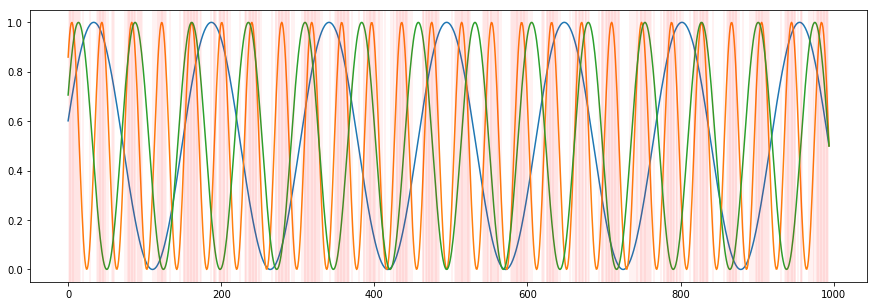

[[ 0.60149683  0.85934606  0.70613636 ...,  0.50000247  0.5
   0.5       ]
 [ 0.62142182  0.91025585  0.74406738 ...,  0.5204377   0.57984835
   0.5424412 ]
 [ 0.6411439   0.95063554  0.7802399  ...,  0.54083878  0.65764722
   0.58457662]
 ..., 
 [ 0.54083878  0.65764722  0.58457662 ...,  0.6411439   0.95063554
   0.7802399 ]
 [ 0.5204377   0.57984835  0.5424412  ...,  0.62142182  0.91025585
   0.74406738]
 [ 0.50000247  0.5         0.5        ...,  0.60149683  0.85934606
   0.70613636]]


In [165]:
#fake data
N = 1000
Npast = 5
xmaster = np.zeros((N,3))
xmaster[:,0] = (np.sin(np.linspace(0,13*np.pi,N))+1)/2
xmaster[:,1] = (np.sin(np.linspace(0,51*np.pi,N))+1)/2
xmaster[:,2] = (np.sin(np.linspace(0,27*np.pi,N))+1)/2
x = np.zeros((N-Npast,3*(Npast+1)))
y = np.zeros((N-Npast,2))

for j in range(3):
    for i in range(Npast+1):
        x[:,j+3*i] = xmaster[Npast-i:N-i,j]
#x = x[:,[3*xx for xx in range(Npast+1)]]
N = len(x)
plt.figure(figsize=(15,5))
plt.plot(x[:,0])
plt.plot(x[:,1])
plt.plot(x[:,2])

xx = []
yy = []
for i in range(N):
    if np.random.randint(100)/100 < x[i,1]:
        y[i,0] = 1.
        xx.append(i)
        yy.append(np.max(x[i,1]))
        plt.axvline(i,lw=0.1,c='r')
#plt.scatter(xx,yy,c='r',marker='X')
plt.show()
x = mapx(x)
print(x)

### RNN-model, fig. 10.4, input Npast parameters

Estimation doesn't converge for real data.

In [166]:
Nit = 1000
eps = 0.0001
Nin = 3*(Npast+1)
print('#Input Parameters', Nin)

U,W,b,V,c,dU,dW,db,dV,dc,yhat,Loss = initialization(Nit,Nin)

for k in range(Nit):
    h,o,yhat[k] = prediction(b[k],c[k],U[k],V[k],W[k],x)
    Loss[k] = get_loss(y,yhat[k])
    print(k,Loss[k])
    db[k],dc[k],do,dU[k],dV[k],dW[k] = gradients(h,o,V[k],W[k],x,y,yhat[k])
    
    if k+1<Nit:
        U[k+1] = U[k] + eps*dU[k]
        W[k+1] = W[k] + eps*dW[k]
        V[k+1] = V[k] + eps*dV[k]
        b[k+1] = b[k] + eps*db[k]
        c[k+1] = c[k] + eps*dc[k]

    

#Input Parameters 18
0 536.253311797
1 508.84592534
2 499.065359438
3 470.184571461
4 454.801575831
5 441.77767837
6 448.705744708
7 430.776189583
8 414.647651329
9 406.971060245
10 397.709667568
11 406.248133898
12 444.409888027
13 439.72179148
14 435.312292355
15 423.0329165
16 409.718780905
17 408.898795815
18 407.08551023
19 404.634295947
20 402.763753056
21 404.506084212
22 394.769402661
23 392.63588455
24 390.181634648
25 389.538316865
26 382.222671464
27 380.463407562
28 380.890352929
29 380.929186458
30 370.060996607
31 348.421046547
32 354.889658486
33 349.66003594
34 287.697253317
35 277.965699164
36 269.764911963
37 270.373615069
38 268.146532115
39 363.150408207
40 421.966128845
41 552.017483277
42 539.114233532
43 526.735752517
44 514.882150195
45 503.551559764
46 492.740095624
47 482.441855251
48 472.648963964
49 463.351660113
50 454.538416873
51 446.196095697
52 438.310125642
53 430.864702158
54 423.842998686
55 417.227384392
56 410.999641713
57 405.141177907
58 399.6332

464 248.549367386
465 248.489561328
466 248.429967602
467 248.370585376
468 248.31141382
469 248.25245211
470 248.193699424
471 248.135154947
472 248.076817866
473 248.018687373
474 247.960762662
475 247.903042932
476 247.845527388
477 247.788215235
478 247.731105685
479 247.674197951
480 247.617491253
481 247.560984811
482 247.504677852
483 247.448569605
484 247.392659302
485 247.33694618
486 247.281429478
487 247.226108439
488 247.170982312
489 247.116050345
490 247.061311792
491 247.006765911
492 246.952411962
493 246.898249209
494 246.844276918
495 246.790494361
496 246.73690081
497 246.683495542
498 246.630277838
499 246.57724698
500 246.524402255
501 246.471742953
502 246.419268365
503 246.366977789
504 246.314870521
505 246.262945865
506 246.211203124
507 246.159641608
508 246.108260626
509 246.057059492
510 246.006037522
511 245.955194037
512 245.904528359
513 245.854039814
514 245.803727728
515 245.753591434
516 245.703630265
517 245.653843557
518 245.604230651
519 245.5547908

922 234.658037825
923 234.644729952
924 234.631461287
925 234.618231694
926 234.605041035
927 234.591889174
928 234.578775975
929 234.565701303
930 234.552665023
931 234.539667001
932 234.526707102
933 234.513785195
934 234.500901145
935 234.488054821
936 234.47524609
937 234.462474822
938 234.449740887
939 234.437044152
940 234.42438449
941 234.41176177
942 234.399175864
943 234.386626643
944 234.374113981
945 234.361637748
946 234.349197819
947 234.336794068
948 234.324426368
949 234.312094594
950 234.299798621
951 234.287538325
952 234.275313582
953 234.263124268
954 234.25097026
955 234.238851436
956 234.226767674
957 234.214718851
958 234.202704848
959 234.190725543
960 234.178780816
961 234.166870547
962 234.154994617
963 234.143152907
964 234.131345299
965 234.119571674
966 234.107831916
967 234.096125906
968 234.084453529
969 234.072814669
970 234.061209209
971 234.049637034
972 234.03809803
973 234.026592082
974 234.015119075
975 234.003678897
976 233.992271435
977 233.9808965

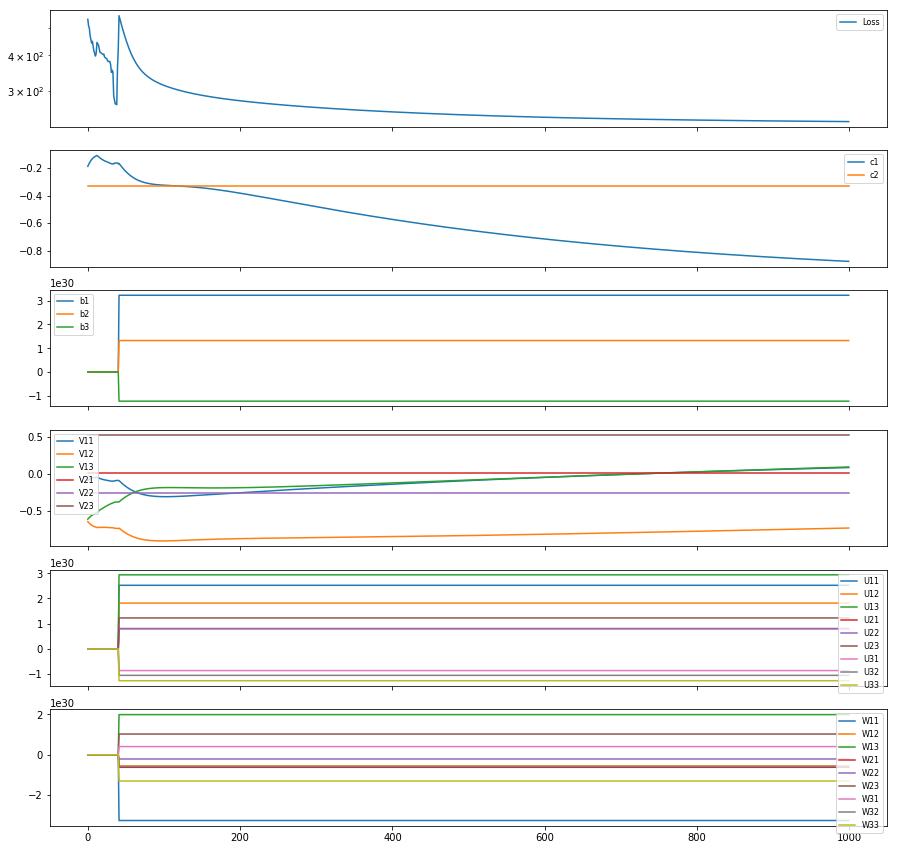

In [167]:
plot_model_evolution(Loss,b,c,U,V,W)

In [168]:
_,_,pred = prediction(b[-1],c[-1],U[-1],V[-1],W[-1],x)

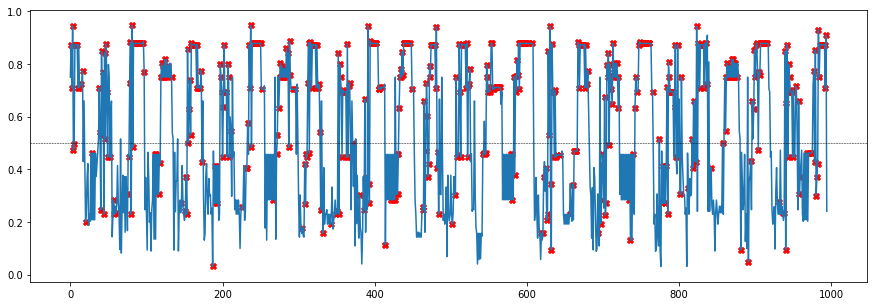

True Positives:   363
False Positives:  105
False Negatives:  155
True Negatives:   372


In [170]:
q = 0.5

plt.figure(figsize=(15,5))
plt.plot(pred[:,0])
for i in range(N):
    if y[i,0]==1.:
        plt.scatter(i,pred[i,0],c='r',marker='X')
plt.axhline(q,lw=0.5,ls='dashed',c='k')
#plt.yscale('log')
plt.show()

C = Confusionmatrix(y,pred,q)